In [1]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

with tf.device('/cpu:0'):
    import cv2
    import os
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.svm import LinearSVC
    from sklearn.metrics import classification_report, accuracy_score
    from tensorflow.keras import layers, models
    from sklearn.preprocessing import LabelEncoder,StandardScaler
    from tensorflow.keras.utils import to_categorical
    import numpy as np
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, classification_report
    from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
    import h5py
    import gc
    import winsound


    gc.enable

    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14412464582263046499
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158652416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16275733151459199455
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
with tf.device('/cpu:0'):
    # Load the numpy array X from the compressed .npz file
    #X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_augemented_train.npz')
    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_4.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_4.npz')
    X_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_val_4.npz')
    #Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_augemented_train.npz')
    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_4.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_4.npz')
    Y_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_val_4.npz')
    
    
    X_train =X_train['X']
    X_test  =X_test ['X']
    X_val   =X_val  ['X']
    Y_train =Y_train['X']
    Y_test  =Y_test ['X']
    Y_val = Y_val ['X']

    # One-hot encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = to_categorical(label_encoder.fit_transform(Y_train))
    y_test_encoded = to_categorical(label_encoder.transform(Y_test))
    y_val_encoded = to_categorical(label_encoder.transform(Y_val))

    X_train = tf.convert_to_tensor(X_train, np.float32)
    X_test = tf.convert_to_tensor(X_test, np.float32)
    X_val = tf.convert_to_tensor(X_val, np.float32)

    
    y_train_encoded = tf.convert_to_tensor(y_train_encoded, np.float32)
    y_test_encoded = tf.convert_to_tensor(y_test_encoded, np.float32)
    y_val_encoded = tf.convert_to_tensor(y_val_encoded, np.float32)

    image_input_shape=(X_train[0].shape)
    num_classes=y_train_encoded.shape[1]


    print(image_input_shape, num_classes)

(64, 64, 3) 50


In [3]:
image_input_shape=(X_train[0].shape)
num_classes=y_train_encoded.shape[1]


print(image_input_shape, num_classes)

(64, 64, 3) 50


In [4]:
# Define input dimensions
#original_input_shape = (64, 64, 3)  # Multi-dimensional input (e.g., image)
#flattened_input_dim = np.prod(original_input_shape)  # Flattened input for perceptron
#latent_dim = 1024  # Size of latent space
#num_classes = y_train_encoded.shape[1]  # Number of classes for classification

In [5]:
with tf.device('/cpu:0'):
    '''ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER ENCODER '''
    # Define the encoder
    def build_encoder(input_shape):
        encoder = models.Sequential(name="enhanced_encoder")
        encoder.add(layers.InputLayer(input_shape=input_shape))
        encoder.add(layers.Conv2D(256, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal', input_shape=input_shape))
        encoder.add(layers.BatchNormalization())
        encoder.add(layers.MaxPooling2D((2, 2)))

        encoder.add(layers.Conv2D(128, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal'))
        encoder.add(layers.BatchNormalization())
        encoder.add(layers.MaxPooling2D((2, 2)))

        encoder.add(layers.Conv2D(64, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal', name="last"))


        return encoder
    
    
    model1 = build_encoder(image_input_shape)
    model1.summary()
    #Get the output of the last layer
    last_layer = model1.get_layer(name="last")
    latent_dim_encoder = last_layer.output_shape
    latent_dim_encoder = latent_dim_encoder[1:]
    print(latent_dim_encoder)

    '''DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER DECODER '''
    # Define the decoder
    def build_decoder(latent_shape):
        decoder = models.Sequential(name="enhanced_decoder")
        decoder.add(layers.InputLayer(input_shape=latent_shape))  # Latent shape input

        decoder.add(layers.Conv2DTranspose(128, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal'))
        decoder.add(layers.BatchNormalization())  # Helps with training stability
        decoder.add(layers.UpSampling2D((2, 2)))  # Doubles the siz

        decoder.add(layers.Conv2DTranspose(256, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal'))
        decoder.add(layers.BatchNormalization())  # Helps with training stability
        decoder.add(layers.UpSampling2D((2, 2)))  # Doubles the size
    
    
        decoder.add(layers.Conv2D(3, (3, 3), activation='linear', padding='same',kernel_initializer='he_normal', name="decoder_output"))
        return decoder
    
    model2 = build_decoder(latent_dim_encoder)
    model2.summary()

    '''CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER CLASSIFIER '''
    #define v\cla\\\
    def build_classifier(latent_dim, num_classes):
        classifier = models.Sequential(name="classifier_x")
        classifier.add(layers.Flatten(input_shape=latent_dim))
        classifier.add(layers.Dense(1024, activation='linear',kernel_initializer='he_normal'))
        classifier.add(layers.Dense(num_classes, activation='softmax'))
        return classifier
    
    model3 = build_classifier(latent_dim_encoder,num_classes)
    model3.summary()
        

Model: "enhanced_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                  

In [6]:
with tf.device('/cpu:0'):
    encoder_model = build_encoder(image_input_shape)
    encoder_model.trainable = True
    decoder_model = build_decoder(latent_dim_encoder)
    decoder_model.trainable = True

    # Combine encoder and decoder for training
    inputs = layers.Input(shape=image_input_shape)
    autoencoder_input = encoder_model(inputs)
    autoencoder_output = decoder_model(autoencoder_input)
    autoencoder = models.Model(inputs=inputs, outputs=[autoencoder_output], name="autoencoder")

    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss=['mse'],  # Reconstruction losses
        metrics=['accuracy']
    )
    autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 enhanced_encoder (Sequentia  (None, 16, 16, 64)       377536    
 l)                                                              
                                                                 
 enhanced_decoder (Sequentia  (None, 64, 64, 3)        377475    
 l)                                                              
                                                                 
Total params: 755,011
Trainable params: 753,475
Non-trainable params: 1,536
_________________________________________________________________


In [7]:
# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta=1e-4)
#lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch)
#checkpoint = ModelCheckpoint('encoder_params.keras', monitor='val_classifier_accuracy', save_best_only=True, save_weights_only=True)

# Train the model
auto = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    #callbacks=[ModelCheckpoint('encoder_decoder.keras', save_weights_only=True)],
    callbacks = [early_stop],
    verbose=1
)

Epoch 1/50
111/111 [==============================] - 11s 66ms/step - loss: 0.8432 - accuracy: 0.4595 - val_loss: 0.5682 - val_accuracy: 0.4455
Epoch 2/50
111/111 [==============================] - 6s 55ms/step - loss: 0.2860 - accuracy: 0.5282 - val_loss: 0.2609 - val_accuracy: 0.5237
Epoch 3/50
111/111 [==============================] - 6s 56ms/step - loss: 0.1932 - accuracy: 0.5736 - val_loss: 0.1828 - val_accuracy: 0.5718
Epoch 4/50
111/111 [==============================] - 6s 56ms/step - loss: 0.1492 - accuracy: 0.6081 - val_loss: 0.1439 - val_accuracy: 0.6057
Epoch 5/50
111/111 [==============================] - 6s 55ms/step - loss: 0.1267 - accuracy: 0.6385 - val_loss: 0.1128 - val_accuracy: 0.6394
Epoch 6/50
111/111 [==============================] - 6s 55ms/step - loss: 0.1081 - accuracy: 0.6622 - val_loss: 0.0976 - val_accuracy: 0.6685
Epoch 7/50
111/111 [==============================] - 6s 55ms/step - loss: 0.0977 - accuracy: 0.6817 - val_loss: 0.0879 - val_accuracy: 0.692

In [8]:
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(800, 800)  # Frequency: 1000 Hz, Duration: 500 ms

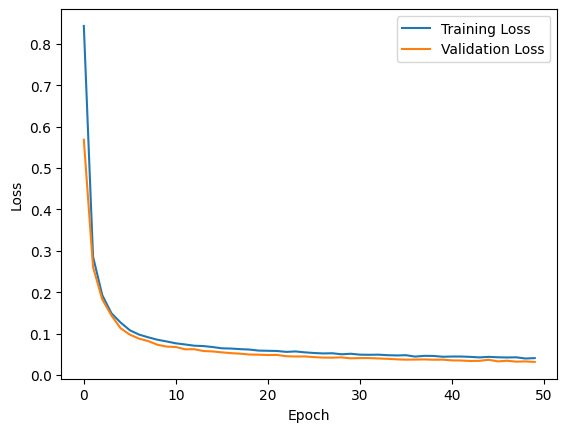

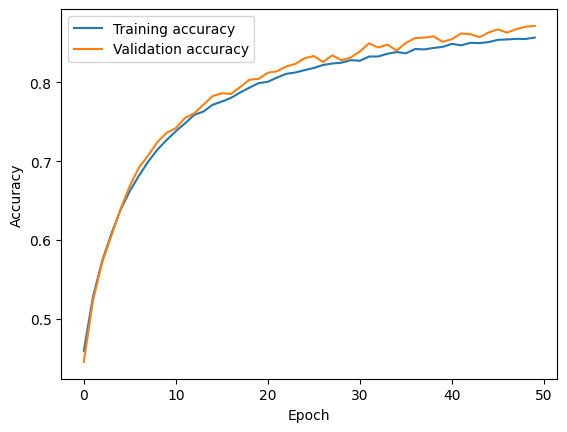

In [9]:
with tf.device('/cpu:0'):
    loss = auto.history['loss']
    val_Loss = auto.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_Loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    Accuracy = auto.history['accuracy']
    val_accuracy = auto.history['val_accuracy']
    plt.plot(Accuracy, label='Training accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


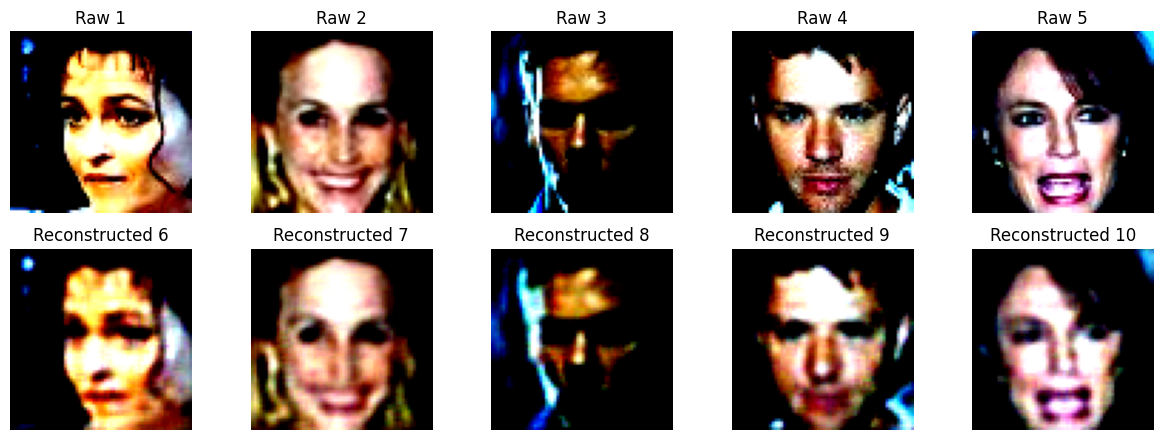

In [35]:
with tf.device('/cpu:0'):

    # Plot 5 random images from the X array
    plt.figure(figsize=(15, 8))  
    for i in range(5):
    
        # Get the raw image from the test dataset
        raw_image = X_test[i]
        
        # Reshape it to match the input shape of the model if necessary (e.g., (128, 128, 3))
        raw_image = np.expand_dims(raw_image, axis=0)  # Add batch dimension
        
        # Get the reconstructed image from the autoencoder
        reconstructed_image = autoencoder.predict(raw_image)
        
        # Squeeze the batch dimension to make it easier to visualize
        raw_image = np.squeeze(raw_image)
        reconstructed_image = np.squeeze(reconstructed_image)
    
        plt.subplot(3, 5, i+1)
        plt.imshow(raw_image) 
        plt.axis('off')  
        plt.title(f"Raw {i+1}")
        
        plt.subplot(3, 5, i+6)  
        plt.imshow(reconstructed_image) 
        plt.axis('off')  
        plt.title(f"Reconstructed {i+6}")
        
    plt.show()


In [11]:
with tf.device('/cpu:0'):
    # Save the encoder parameters
    encoder_model.save_weights(r'C:\Users\princ\Downloads\Vision datasets\temp\cnn_encoder_weights.h5')
    print("Encoder parameters saved .h5.")
    
    
    with h5py.File(r'C:\Users\princ\Downloads\Vision datasets\temp\cnn_encoder_weights.h5', 'r') as f:
        print("Keys in the file:", list(f.keys()))

    

Encoder parameters saved .h5.
Keys in the file: ['batch_normalization_4', 'batch_normalization_5', 'conv2d_2', 'conv2d_3', 'last', 'max_pooling2d_2', 'max_pooling2d_3', 'top_level_model_weights']


In [20]:
gc.collect()
tf.keras.backend.clear_session()

In [21]:

# Load the pretrained encoder parameters
pretrained_encoder = build_encoder(image_input_shape)
pretrained_encoder.load_weights(r'C:\Users\princ\Downloads\Vision datasets\temp\cnn_encoder_weights.h5', by_name=True)
print("Pretrained encoder weights loaded.")
# Freeze encoder layers to prevent further training
pretrained_encoder.trainable = False
# Build the classifier
classifier_model = build_classifier(latent_dim_encoder, num_classes)
classifier_model.trainable = True
# Combine encoder and classifier
inputs = layers.Input(image_input_shape)
encoded_features = pretrained_encoder(inputs)
classified_output = classifier_model(encoded_features)
encoder_classifier = models.Model(inputs=inputs, outputs=classified_output, name="encoder_classifier")


# Compile the encoder-classifier
encoder_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
    

Pretrained encoder weights loaded.


In [22]:
with tf.device('/gpu:0'):
    early_stop2 = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, min_delta=1e-4)
    # Train the Encoder-Classifier Model
    history = encoder_classifier.fit(
        X_train,  # Training input data
        y_train_encoded,  # Training target labels (one-hot encoded)
        batch_size=32,  # Batch size for training
        epochs=200,  # Number of epochs to train
        callbacks = [early_stop2],
        validation_data=(X_val, y_val_encoded),  # Validation data
        shuffle = True
    )


Epoch 1/200
111/111 [==============================] - 3s 19ms/step - loss: 6.1817 - accuracy: 0.0860 - val_loss: 4.7084 - val_accuracy: 0.1451
Epoch 2/200
111/111 [==============================] - 2s 17ms/step - loss: 3.7515 - accuracy: 0.2312 - val_loss: 3.9343 - val_accuracy: 0.2111
Epoch 3/200
111/111 [==============================] - 2s 16ms/step - loss: 2.8971 - accuracy: 0.3453 - val_loss: 3.6585 - val_accuracy: 0.2625
Epoch 4/200
111/111 [==============================] - 2s 17ms/step - loss: 2.4142 - accuracy: 0.4362 - val_loss: 3.2707 - val_accuracy: 0.3034
Epoch 5/200
111/111 [==============================] - 2s 17ms/step - loss: 2.0057 - accuracy: 0.4973 - val_loss: 3.2183 - val_accuracy: 0.3113
Epoch 6/200
111/111 [==============================] - 2s 16ms/step - loss: 1.6995 - accuracy: 0.5768 - val_loss: 3.1124 - val_accuracy: 0.3470
Epoch 7/200
111/111 [==============================] - 2s 16ms/step - loss: 1.4629 - accuracy: 0.6289 - val_loss: 3.0871 - val_accuracy:

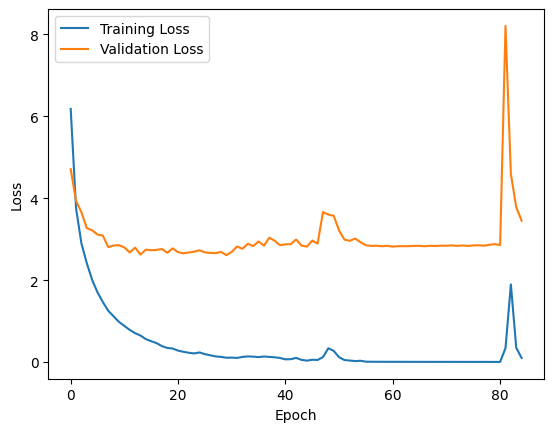

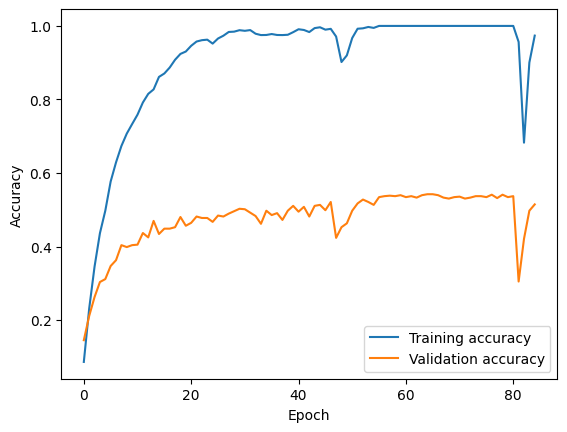

In [23]:
with tf.device('/cpu:0'):
    loss = history.history['loss']
    val_Loss = history.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_Loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    Accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(Accuracy, label='Training accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [24]:
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(800, 800)  # Frequency: 1000 Hz, Duration: 500 ms

In [25]:
# Print training summary
print("Training completed!")
# Step 1: Generate predictions
predictions = encoder_classifier.predict(X_test)
# Step 2: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
# Step 3: Get true class labels (decode if one-hot encoded)
true_classes = np.argmax(y_test_encoded, axis=1)
# Step 4: Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

Training completed!
24/24 [==============================] - 0s 16ms/step
Prediction Accuracy: 60.50%


In [26]:
def visualize_results(y_test, y_predict):
    # Convert predictions to class labels (if necessary)
    y_predict_class = np.argmax(y_predict, axis=1)
    
    # Convert y_test from one-hot encoding to class labels (if necessary)
    y_test_class = np.argmax(y_test, axis=1)  # Only if y_test is one-hot encoded

    # Compute confusion matrix
    cm = confusion_matrix(y_test_class, y_predict_class)

    # Plot confusion matrix with a wider figure
    plt.figure(figsize=(23, 23))  # Wider graph: 12 units wide, 6 units high
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(y_test_class))), yticklabels=np.arange(len(np.unique(y_test_class))))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def class_wise_accuracy(y_test, y_predict):
    # Convert predictions and ground truth to class labels (if necessary)
    y_predict_class = np.argmax(y_predict, axis=1)  # for multi-class outputs
    y_test_class = np.argmax(y_test, axis=1)  # for one-hot encoded labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test_class, y_predict_class)

    # Calculate class-wise accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)  # Diagonal elements (correct predictions) / Row sums (total class instances)

    # Print class-wise accuracy
    #print("Class-wise accuracy:")
    #for i, accuracy in enumerate(class_accuracies):
    #    print(f"Class {i}: {accuracy * 100:.2f}%")

    # Plot class-wise accuracy as a bar chart with a wider figure
    plt.figure(figsize=(20, 6))  # Wider graph: 12 units wide, 6 units high
    plt.bar(range(len(class_accuracies)), class_accuracies * 100, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(range(len(class_accuracies)))
    plt.ylim(0, 100)
    plt.show()

    return class_accuracies

import matplotlib.pyplot as plt
import numpy as np

def show_images_from_class(X, y, class_label, num_images=5):
    """
    Display a given number of images from a specified class, arranged with 5 images per row.
    
    Parameters:
    - X: The image data (features) as a numpy array or pandas dataframe.
    - y: The labels corresponding to the images.
    - class_label: The class label for which to show the images.
    - num_images: Number of images to display (default is 5).
    """
    # Find the indices of the images that belong to the given class
    class_indices = np.where(y == class_label)[0]
    
    # Randomly select 'num_images' indices from the class
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    
    # Calculate the number of rows needed to display the images in 5 per row
    num_rows = (num_images // 5) + (num_images % 5 != 0)
    
    # Set up the plot
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_rows, 5, i+1)  # Rows x 5 columns
        plt.imshow(X[idx], cmap='gray')  # Assuming grayscale images, adjust if RGB
        plt.title(f"Class {class_label}")
        plt.axis('off')  # Hide axes
    
    plt.show()



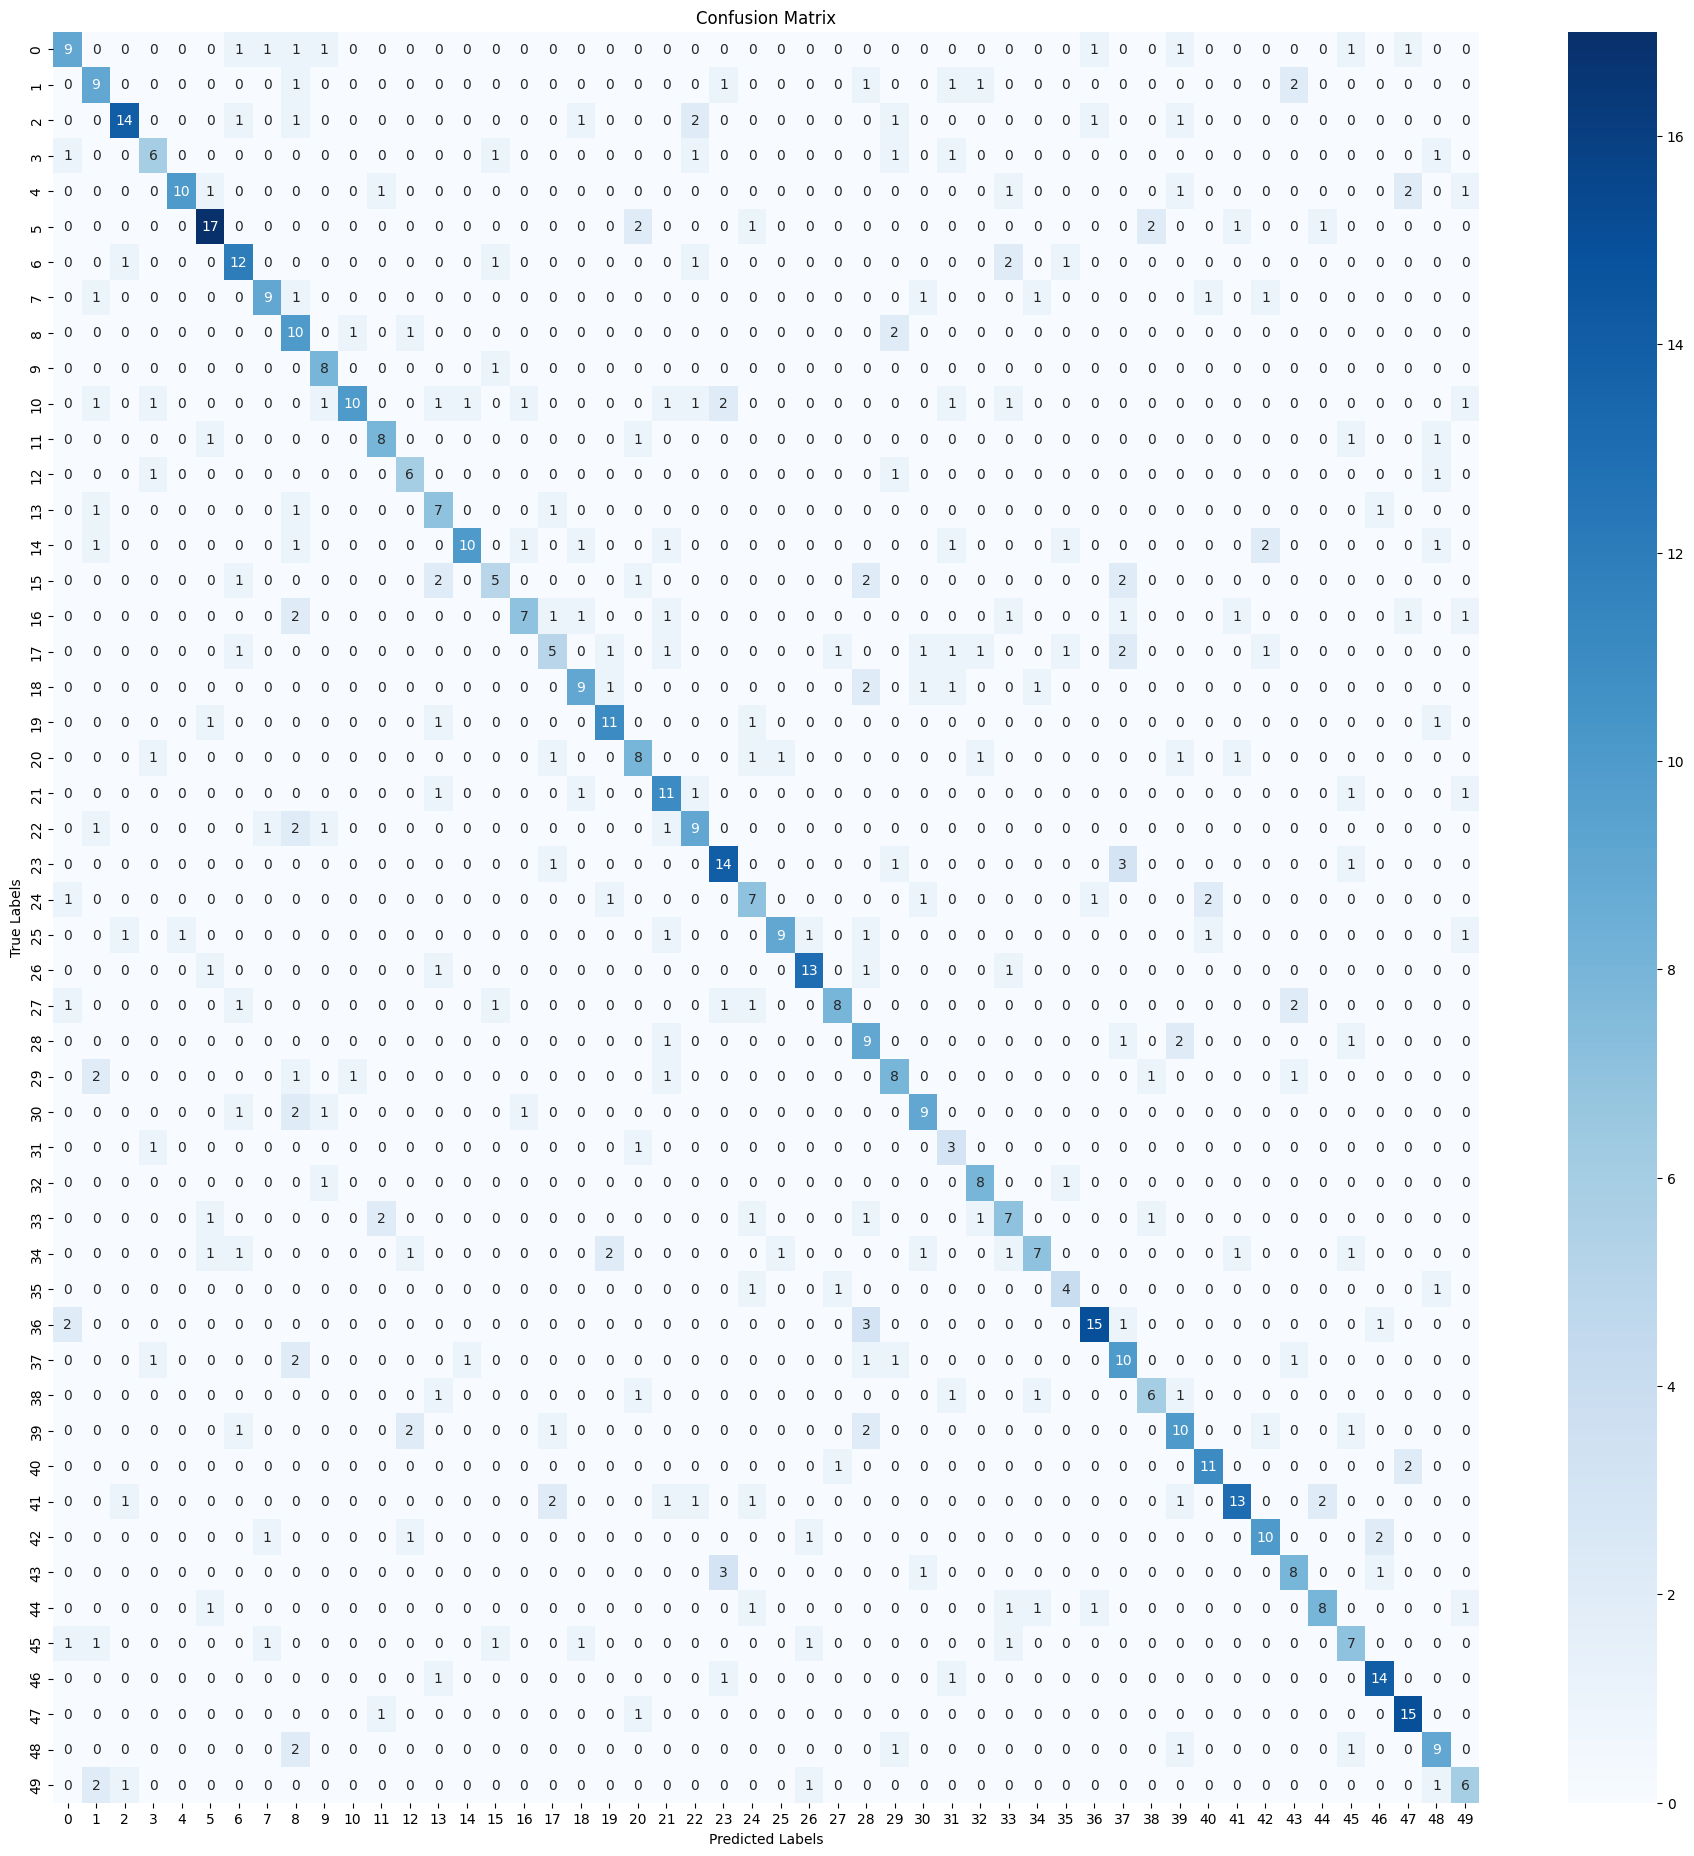

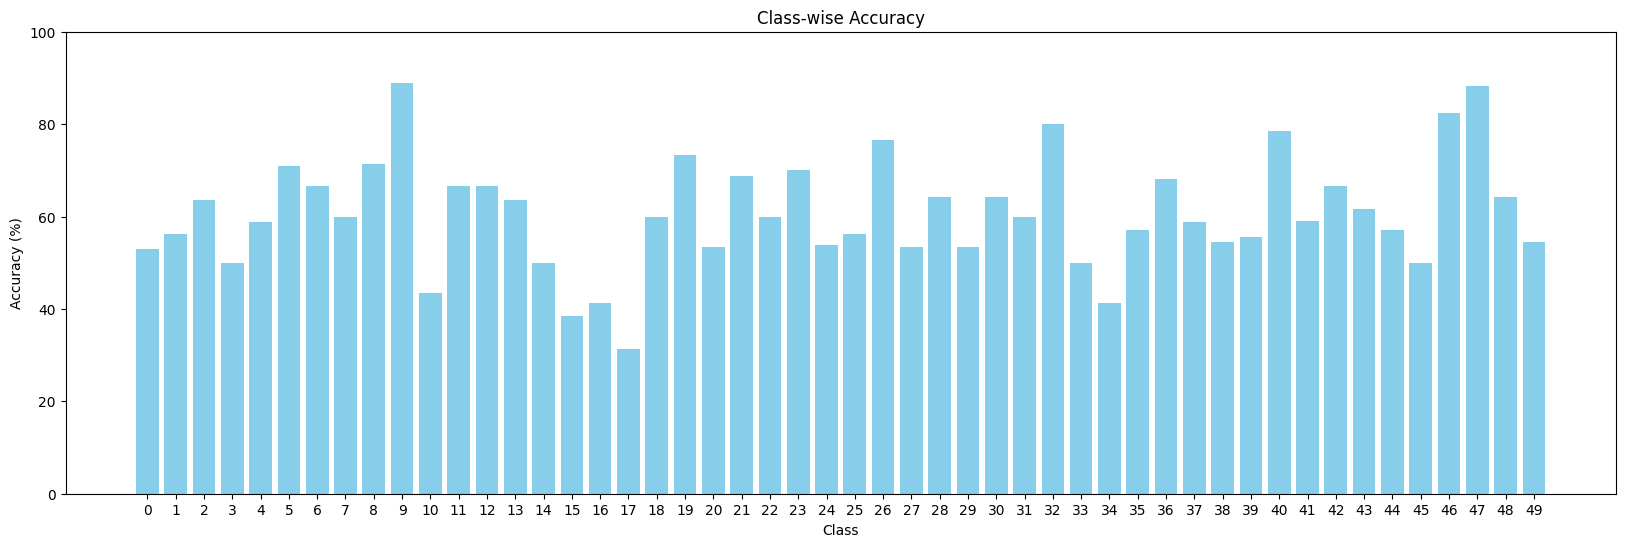

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

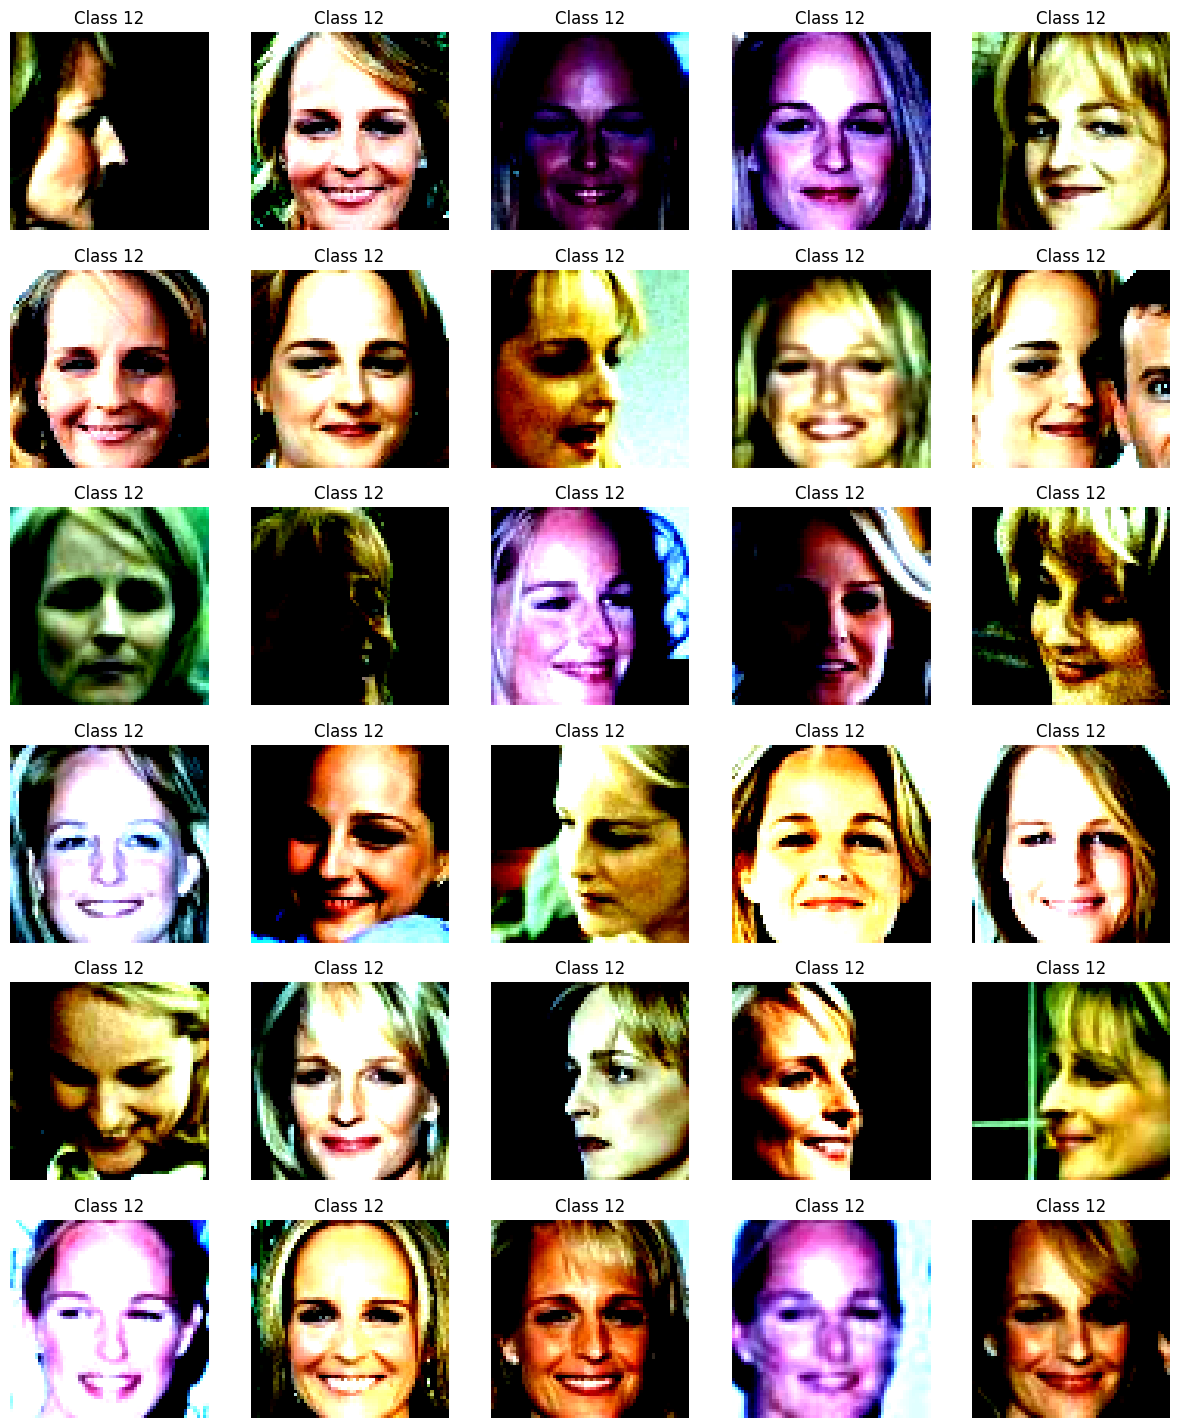

In [27]:

visualize_results(y_test_encoded, predictions)
class_wise_accuracy(y_test_encoded, predictions)
show_images_from_class(X_train, Y_train, class_label=12, num_images=30)
